# Data Cleaning / Wrangling

**Goal** : gather all the data in one clean csv file


## Step 1 : get consumption

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [54]:
df1 = pd.read_csv("./data/eco2mix_regional_cons_def.csv", delimiter=";",parse_dates=["Date - Heure"])

In [55]:
df1.head(2)

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW)
0,11,Ile-de-France,Données consolidées,2017-11-30,09:00,2017-11-30 08:00:00,12001.0,997.0,NaN,13.0,1.0,6.0,NaN,155.0,10829.0
1,11,Ile-de-France,Données consolidées,2017-11-30,11:30,2017-11-30 10:30:00,12159.0,1065.0,NaN,15.0,9.0,8.0,NaN,146.0,10915.0


In [56]:
df1.shape

(89136, 15)

In [57]:
consumption = df1[["Date - Heure","Consommation (MW)"]].copy().sort_values(by=['Date - Heure'])

In [58]:
# Count duplicates
# Identical dates
print(consumption.duplicated(subset='Date - Heure').sum())
# Identical dates and conso
print(consumption.duplicated().sum())

10
4


We have duplicated dates with different consumptions, **interesting** !

In [59]:
# Remove duplicates
consumption.drop_duplicates(inplace=True,subset='Date - Heure')

In [60]:
# Rename columns
consumption.columns = ['Date', 'Conso']

In [61]:
consumption.head()

,Date,Conso
31426,2012-12-31 23:00:00,NaN
31870,2012-12-31 23:30:00,9134.0
31427,2013-01-01 00:00:00,8822.0
31871,2013-01-01 00:30:00,8499.0
67104,2013-01-01 01:00:00,8229.0


In [62]:
# Check days with missing half hours
count_half_hours = consumption.set_index('Date').resample('D').count()
count_half_hours[count_half_hours['Conso'] != 48]

,Conso
Date,
2012-12-31,1
2013-10-27,46
2014-10-26,46
2015-10-25,46
2016-10-30,46
2017-10-29,46
2018-01-31,46


We have days with less that 48 half hours, **interesting** !

## Step 3 : get all half hours

In [63]:
from datetime import timedelta, datetime

print(consumption['Date'].min())
print(consumption['Date'].max())


dates = []
dt = consumption['Date'].min()

for i in range(90000):
    dt += timedelta(minutes=30)
    dates.append(dt)
    
half_hours = pd.DataFrame(dates,columns=['Date'])

half_hours.head()

2012-12-31 23:00:00
2018-01-31 22:30:00


,Date
0,2012-12-31 23:30:00
1,2013-01-01 00:00:00
2,2013-01-01 00:30:00
3,2013-01-01 01:00:00
4,2013-01-01 01:30:00


## Step 2 : get temperatures

In [64]:
df2 = pd.read_csv("./data/meteo-paris.csv")

In [65]:
df2.dtypes

dt                       int64
dt_iso                  object
city_id                  int64
city_name              float64
lat                    float64
lon                    float64
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
rain_24h               float64
rain_today             float64
snow_1h                float64
snow_3h                float64
snow_24h               float64
snow_today             float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [66]:
df2['dt'] = pd.to_datetime(df2['dt'],unit='s')

In [67]:
df2.head(3)

,dt,dt_iso,city_id,city_name,lat,lon,temp,temp_min,temp_max,pressure,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2012-10-01 13:00:00,2012-10-01 13:00:00 +0000 UTC,2988507,NaN,NaN,NaN,293.320000,291.150000,298.150000,1017,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,Sky is Clear,01d
1,2012-10-01 14:00:00,2012-10-01 14:00:00 +0000 UTC,2988507,NaN,NaN,NaN,293.324271,293.324271,293.324271,1017,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is Clear,01
2,2012-10-01 15:00:00,2012-10-01 15:00:00 +0000 UTC,2988507,NaN,NaN,NaN,293.334926,293.334926,293.334926,1017,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is Clear,01


In [68]:
weather = df2[['dt','temp']].copy()
weather.columns = ['Date', 'Temp']

In [69]:
weather.head(3)

,Date,Temp
0,2012-10-01 13:00:00,293.320000
1,2012-10-01 14:00:00,293.324271
2,2012-10-01 15:00:00,293.334926


In [70]:
# Count duplicates
weather.duplicated().sum()

3404

In [71]:
# Remove duplicates
weather.drop_duplicates(inplace=True,subset='Date')

## Step 3 : Merge everything together

[Documentation on how to merge with pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html)


![How to merge](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2017/03/join-types-merge-names.jpg)


**Inner Merge / Inner join** – The default Pandas behaviour, only keep rows where the merge “on” value exists in both the left and right dataframes.

**Left Merge / Left outer join** – Keep every row in the left dataframe. Where there are missing values of the “on” variable in the right dataframe, add empty / NaN values in the result.

**Right Merge / Right outer join** – Keep every row in the right dataframe. Where there are missing values of the “on” variable in the left column, add empty / NaN values in the result.

**Outer Merge / Full outer join** – A full outer join returns all the rows from the left dataframe, all the rows from the right dataframe, and matches up rows where possible, with NaNs elsewhere.

### Merge consumption and weather

In [75]:
print("Consumption shape",consumption.shape)
print("Weather shape",weather.shape)

leftmerge = pd.merge(consumption,weather,on='Date',how="left")
innermerge = pd.merge(consumption,weather,on='Date',how="inner")

print("Left merge", leftmerge.shape)
print("Inner merge", innermerge.shape)
leftmerge.sample(10)

Consumption shape (89126, 2)
Weather shape (45410, 2)
Left merge (89126, 3)
Inner merge (43211, 3)


,Date,Conso,Temp
33043,2014-11-20 10:30:00,11077.0,NaN
5269,2013-04-20 17:30:00,7807.0,NaN
6258,2013-05-11 08:00:00,6898.0,283.730000
5025,2013-04-15 15:30:00,8290.0,NaN
28270,2014-08-12 23:00:00,5054.0,285.464333
46552,2015-08-28 21:00:00,6938.0,289.070000
28058,2014-08-08 13:00:00,6847.0,292.419000
87189,2017-12-22 14:30:00,9654.0,NaN
4854,2013-04-12 02:00:00,6971.0,285.350000
32376,2014-11-06 13:00:00,9446.0,283.063333


### Merge with dates

In [76]:
df = pd.merge(half_hours,leftmerge,on='Date',how="left")

In [22]:
df.shape

(90000, 3)

In [77]:
df.sample(10)

,Date,Conso,Temp
9311,2013-07-13 23:00:00,5766.0,289.820000
57541,2016-04-13 18:00:00,8755.0,287.606079
87724,2018-01-02 13:30:00,10580.0,NaN
42823,2015-06-12 03:00:00,5134.0,290.457184
33938,2014-12-09 00:30:00,9726.0,NaN
1451,2013-01-31 05:00:00,8961.0,285.500000
4651,2013-04-07 21:00:00,10179.0,278.240000
73499,2017-03-12 05:00:00,6682.0,278.480000
48668,2015-10-11 21:30:00,7745.0,NaN
60941,2016-06-23 14:00:00,8359.0,303.840000


In [78]:
df.set_index('Date',inplace=True)
df.sort_index(inplace=True)

# Step 4 : interpolate missing temperatures
We want to keep our historical consumptions (which are precious) so we will interpolate missing values for temperature

First question : where are missing values ?

In [80]:
df.interpolate('linear',limit=4,inplace=True)

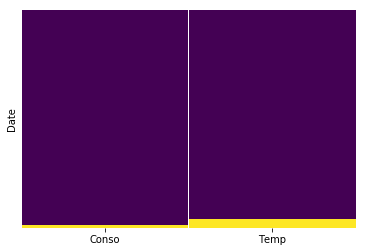

In [26]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [27]:
weather['Date'].max()

Timestamp('2017-12-06 14:00:00')

In [28]:
df[:'2017-12-05'].isnull().sum()

Conso    0
Temp     1
dtype: int64

In [29]:
df.head(10)

,Conso,Temp
Date,,
2012-12-31 23:30:00,9134.0,NaN
2013-01-01 00:00:00,8822.0,278.91
2013-01-01 00:30:00,8499.0,278.91
2013-01-01 01:00:00,8229.0,278.91
2013-01-01 01:30:00,8150.0,278.91
2013-01-01 02:00:00,7848.0,278.91
2013-01-01 02:30:00,7667.0,278.91
2013-01-01 03:00:00,7440.0,278.91
2013-01-01 03:30:00,7378.0,278.91


# Step 5 : Automate everything : 

In [90]:
def get_data(consumption_csv="./data/eco2mix_regional_cons_def.csv",weather_csv="./data/meteo-paris.csv"):
    """
    A function to get consumption and weather data
    Do the wrangling
    And return a nice & compact dataframe
    
    """
    # consumptions
    consumption =  pd.read_csv(consumption_csv, delimiter=";",parse_dates=["Date - Heure"], usecols = ["Date - Heure","Consommation (MW)"])
    consumption.drop_duplicates(inplace=True,subset='Date - Heure')
    consumption.columns = ['Date', 'Conso']
    # half hours
    start_date = consumption['Date'].min()
    dates = []
    for i in range(90000):
        start_date += timedelta(minutes=30)
        dates.append(start_date)
    half_hours = pd.DataFrame(dates,columns=['Date'])
    # weather
    weather = pd.read_csv(weather_csv,usecols=['dt','temp'])
    weather['dt'] = pd.to_datetime(weather['dt'],unit='s')
    weather.columns = ['Date', 'Temp']
    weather.drop_duplicates(inplace=True,subset='Date')
    # Merging
    df1 = pd.merge(consumption,weather,on='Date',how="left")
    df2 = pd.merge(half_hours,df1,on='Date',how="left")
    df2.interpolate('linear',limit=4,inplace=True)
    return df2.dropna()

In [91]:
df = get_data()


In [92]:
df.sample(100)

,Date,Conso,Temp
10043,2013-07-29 05:00:00,5679.0,290.670000
63667,2016-08-19 09:00:00,6717.0,293.690000
54073,2016-02-01 12:00:00,10448.0,285.150000
36324,2015-01-27 17:30:00,12902.0,277.539833
80261,2017-07-31 02:00:00,4376.0,289.000000
81900,2017-09-03 05:30:00,4737.0,282.425000
77203,2017-05-28 09:00:00,6150.0,296.150000
21603,2014-03-27 01:00:00,8149.0,276.240000
9966,2013-07-27 14:30:00,6733.0,302.215000
43868,2015-07-03 21:30:00,7823.0,301.690000


In [94]:
count_half_hours = df.set_index('Date').resample('D').count()
count_half_hours[count_half_hours['Conso'] != 48]

,Conso,Temp
Date,,
2017-12-06,33,33


In [96]:
df['Date'].max()

Timestamp('2017-12-06 16:00:00')

In [97]:
df.isnull().sum()

Date     0
Conso    0
Temp     0
dtype: int64

# That's Clean !